In [44]:
# importing required libraries
import matplotlib
import pandas as pd
import numpy as np
import math
from numpy import argmax
import sys
from IPython.display import display
import warnings
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Concatenate

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import callbacks

from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
import numpy as np
import time
import statistics


# library options
%matplotlib inline
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

In [2]:
# Monte Carlo Dropout Layer
class MonteCarloDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

# Read in the Train and Test data

In [3]:
# Control Parameters:
savedDatasets = True
onlyBuyers = False
oversampling = False
undersampling = False
TomekLinks = False
SMOTE = False
weight = False
cross_validation = True


In [4]:
if savedDatasets:
    X_train = np.array(pd.read_parquet('data/X_train.parquet')).astype('float')
    X_test = np.array(pd.read_parquet('data/X_test.parquet')).astype('float')
    
    y_test_class = np.array(pd.read_parquet('data/y_test.parquet')['sum_payments_package_key_ltv_class'])
    y_train_class = np.array(pd.read_parquet('data/y_train.parquet')['sum_payments_package_key_ltv_class'])                        
    #y_test_class = np.array(pd.read_parquet('data/y_test.parquet')['sum_payments_package_key_ltv_class'].apply(lambda x: 0 if x == 'low' else 1 if x == "medium" else 2 if x == "high" else -1)).astype('float')
    #y_train_class = np.array(pd.read_parquet('data/y_train.parquet')['sum_payments_package_key_ltv_class'].apply(lambda x: 0 if x == 'low' else 1 if x == "medium" else 2 if x == "high" else -1)).astype('float')
    y_test_reg = np.array(pd.read_parquet('data/y_test.parquet')['sum_payments_package_key_ltv']).astype('float')
    y_train_reg = np.array(pd.read_parquet('data/y_train.parquet')['sum_payments_package_key_ltv']).astype('float')
    n_class = 3    

# Manipulate the data to enhance Modelling

## Oversampling

In [5]:
if oversampling:
    df_majority = train[train["buyer"] == 0]
    df_minority = train[train["buyer"] == 1]

    n_samples = round(len(df_majority) * 0.75)

    df_minority_upsampled = resample(df_minority, replace=True, n_samples=n_samples, random_state=42) 
    train_oversampled = pd.concat([df_majority, df_minority_upsampled])


    # Display new class counts
    print (train_oversampled['buyer'].value_counts())

    train = train_oversampled

## Under-/Downsampling

In [6]:
if undersampling:
    df_majority = train[train["buyer"] == 0]
    df_minority = train[train["buyer"] == 1]

    n_samples = len(df_minority)

    df_majority_downsample = resample(df_majority, replace=True, n_samples=n_samples,random_state=42) 
    train_undersampled = pd.concat([df_majority_downsample, df_minority])

    # Display new class counts
    print (train_undersampled['buyer'].value_counts())

    train = train_undersampled

## Tomek Links

In [7]:
if TomekLinks:
    df_majority = train[train["buyer"] == 0]
    df_minority = train[train["buyer"] == 1]

    undersample = TomekLinks()

    X_train_Tomek, y_train_Tomek  = undersample.fit_resample()

## Decide which Techniques are applied before looking at SMOTE

In [8]:
# prepare regression output as well as classification output and have one input for both
if not savedDatasets:
    train.drop(labels=['buyer'], axis = 1, inplace = True)
    test.drop(labels=['buyer'], axis = 1, inplace = True)

    y_train = np.array(train['sum_payments_package_key_ltv']).astype('float')
    y_test = np.array(test['sum_payments_package_key_ltv']).astype('float')

    X_train = np.array(train.drop(['sum_payments_package_key_ltv', 'n_payments_package_key_ltv'], axis = 1)).astype('float')
    X_test = np.array(test.drop(['sum_payments_package_key_ltv', 'n_payments_package_key_ltv'], axis = 1)).astype('float')

    n_features = X_train.shape[1]

## SMOTE

In [9]:
#SMOTE
if SMOTE:
    X = X_train.astype('float')
    Y = y_train.astype('float')
    sm = SMOTE(random_state = 42)
    x_train_SMOTE, y_train_SMOTE = sm.fit_resample(train.drop(labels = ['sum_payments_package_key_ltv'], axis = 1), train['sum_payments_package_key_ltv'])
    print (x_train_SMOTE['buyer'].value_counts())

# Check Data before MLP 

In [10]:
print('Training Features Shape:', X_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Training Labels Classification Shape:', y_train_class.shape)
print('Testing Labels Classification Shape:', y_test_class.shape)

Training Features Shape: (111791, 180)
Testing Features Shape: (27948, 180)
Training Labels Classification Shape: (111791,)
Testing Labels Classification Shape: (27948,)


# Create weights for the different classes 

In [11]:
if weight:
    test_temp = pd.DataFrame(pd.read_pickle('y_train_scaled.pickle'))
    test_temp.sort_values(by='sum_payments_package_key_ltv', inplace = True)
    test_temp.reset_index(inplace = True, drop = True)

    plt.figure(figsize=(20, 8))
    #Create the plots
    plt.scatter(test_temp.index,test_temp['sum_payments_package_key_ltv'], color='blue', label = 'Labels Test', s = 0.01)
    #Create the title, axis description and legend
    plt.title('Labels Test')
    plt.ylabel('LTV Test')
    #plt.xlabel("screen_density")
    plt.legend()
    #plt.grid()
    plt.xticks(rotation = 45)
    plt.rcParams.update({'font.size': 12})

# Hyperparameter Tuning

In [12]:
def model_builder(hp):
    model = keras.Sequential()

    # layer 01
    layer_01 = hp.Choice('layer_01', values = ['False','True'])
    if layer_01:
        units_01 = hp.Int('units_01', min_value=64, max_value=1024, step=32)
        activation_01 = hp.Choice('activation_01', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_01 = hp.Choice('kernel_01', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_01, activation = activation_01, kernel_initializer=kernel_initializer_01, input_shape = (X_train.shape[1],)))
    
    batch_01 = hp.Choice('batch_01', values = ['False','True'])
    if batch_01:
        model.add(BatchNormalization())
    
    drop_01 = hp.Choice('drop_01', values = ['False','drop','Monte'])
    if drop_01 == 'drop':
        dropout_01 = hp.Float('dropout_01', min_value=0.1, max_value=0.6, step=0.1)
        model.add(Dropout(dropout_01))
    elif drop_01 == 'Monte':
        monte_01 = hp.Float('monte_01', min_value=0.1, max_value=0.6, step=0.1)
        model.add(MonteCarloDropout(monte_01))
    
    # layer 02
    layer_02 = hp.Choice('layer_02', values = ['False','True'])
    if layer_02:
        units_02 = hp.Int('units_02', min_value = 32, max_value = 512, step=32)
        activation_02 = hp.Choice('activation_02', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_02 = hp.Choice('kernel_02', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_02, activation = activation_02, kernel_initializer=kernel_initializer_02))
    
    batch_02 = hp.Choice('batch_02', values = ['False','True'])
    if batch_02:
        model.add(BatchNormalization())
        
    drop_02 = hp.Choice('drop_02', values = ['False','drop','Monte'])
    if drop_02:
        dropout_02 = hp.Float('dropout_02', min_value=0.1, max_value=0.6, step=0.1)
        model.add(Dropout(dropout_02))
    elif drop_02 == 'Monte':
        monte_02 = hp.Float('monte_02', min_value=0.1, max_value=0.6, step=0.1)
        model.add(MonteCarloDropout(monte_02))
    
    # layer 03
    layer_03 = hp.Choice('layer_03', values = ['False','True'])
    if layer_03:
        units_03 = hp.Int('units_03', min_value = 32, max_value = 512, step=32)
        activation_03 = hp.Choice('activation_03', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_03 = hp.Choice('kernel_03', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_03, activation = activation_03, kernel_initializer=kernel_initializer_03))
    
    drop_03 = hp.Choice('drop_03', values = ['False','drop','Monte'])
    if drop_03:
        dropout_03 = hp.Float('dropout_03', min_value=0.1, max_value=0.6, step=0.1)
        model.add(Dropout(dropout_03))
    elif drop_03 == 'Monte':
        monte_03 = hp.Float('monte_03', min_value=0.1, max_value=0.6, step=0.1)
        model.add(MonteCarloDropout(monte_03))
    
    batch_03 = hp.Choice('batch_03', values = ['False','True'])
    if batch_03:
        model.add(BatchNormalization())
    
    # layer 04
    layer_04 = hp.Choice('layer_04', values = ['False','True'])
    if layer_04:
        units_04 = hp.Int('units_04', min_value = 16, max_value = 512, step=32)
        activation_04 = hp.Choice('activation_04', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_04 = hp.Choice('kernel_04', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_04, activation = activation_04, kernel_initializer=kernel_initializer_04))
    
    drop_04 = hp.Choice('drop_04', values = ['False','drop','Monte'])
    if drop_04:
        dropout_04 = hp.Float('dropout_04', min_value=0.1, max_value=0.6, step=0.1)
        model.add(Dropout(dropout_04))
    elif drop_04 == 'Monte':
        monte_04 = hp.Float('monte_04', min_value=0.1, max_value=0.6, step=0.1)
        model.add(MonteCarloDropout(monte_04))
        
    batch_04 = hp.Choice('batch_04', values = ['False','True'])
    if batch_04:
        model.add(BatchNormalization())
    
    # layer 05
    layer_05 = hp.Choice('layer_05', values = ['False','True'])
    if layer_05:
        units_05 = hp.Int('units_05', min_value = 16, max_value = 256, step=32)
        activation_05 = hp.Choice('activation_05', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_05 = hp.Choice('kernel_05', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_05, activation = activation_05, kernel_initializer=kernel_initializer_05))
    
    drop_05 = hp.Choice('drop_05', values = ['False','drop','Monte'])
    if drop_05:
        dropout_05 = hp.Float('dropout_05', min_value=0.1, max_value=0.6, step=0.1)
        model.add(Dropout(dropout_05))
    elif drop_05 == 'Monte':
        monte_05 = hp.Float('monte_05', min_value=0.1, max_value=0.6, step=0.1)
        model.add(MonteCarloDropout(monte_05))
        
    batch_05 = hp.Choice('batch_05', values = ['False','True'])
    if batch_05:
        model.add(BatchNormalization())
    
    # layer 06
    layer_06 = hp.Choice('layer_06', values = ['False','True'])
    if layer_06:
        units_06 = hp.Int('units_06', min_value = 4, max_value = 16, step=4)
        activation_06 = hp.Choice('activation_06', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_06 = hp.Choice('kernel_06', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_06, activation = activation_06, kernel_initializer=kernel_initializer_06))
        
    # layer 07
    layer_07 = hp.Choice('layer_07', values = ['False','True'])
    if layer_07:
        units_07 = hp.Int('units_07', min_value = 4, max_value = 16, step=4)
        activation_07 = hp.Choice('activation_07', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_07 = hp.Choice('kernel_07', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_07, activation = activation_07, kernel_initializer=kernel_initializer_07))    
    
    # layer 08
    layer_08 = hp.Choice('layer_08', values = ['False','True'])
    if layer_08:
        units_08 = hp.Int('units_08', min_value = 4, max_value = 16, step=4)
        activation_08 = hp.Choice('activation_08', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_08 = hp.Choice('kernel_08', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_08, activation = activation_08, kernel_initializer=kernel_initializer_08))
        
    # layer 09
    layer_09 = hp.Choice('layer_06', values = ['False','True'])
    if layer_09:
        units_09 = hp.Int('units_06', min_value = 4, max_value = 16, step=4)
        activation_09 = hp.Choice('activation_09', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_09 = hp.Choice('kernel_09', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_09, activation = activation_09, kernel_initializer=kernel_initializer_09))
        
    # layer 10
    layer_10 = hp.Choice('layer_10', values = ['False','True'])
    if layer_10:
        units_10 = hp.Int('units_10', min_value = 4, max_value = 16, step=4)
        activation_10 = hp.Choice('activation_10', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_10 = hp.Choice('kernel_10', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_10, activation = activation_10, kernel_initializer=kernel_initializer_10))
    
    model.add(Dense(n_class, activation='softmax'))
    
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_crossentropy','accuracy'])

    return model

In [13]:
tuner = kt.Hyperband(model_builder,
                     objective = 'sparse_categorical_crossentropy',
                     max_epochs = 40,
                     factor = 6,
                     project_name = 'MLP_Classification_withGradient_01')

stop_early = callbacks.EarlyStopping(monitor='accuracy', patience=7)

INFO:tensorflow:Reloading Oracle from existing project ./MLP_Classification_withGradient_01/oracle.json
INFO:tensorflow:Reloading Tuner from ./MLP_Classification_withGradient_01/tuner0.json


In [14]:
tuner.search(X_train, y_train_class, epochs=100, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print('The hyperparameter search is complete. The optimal model is:')
print(best_hps)

INFO:tensorflow:Oracle triggered exit
The hyperparameter search is complete. The optimal model is:


In [15]:
tuner.results_summary()

Results summary
Results in ./MLP_Classification_withGradient_01
Showing 10 best trials
Objective(name='sparse_categorical_crossentropy', direction='min')
Trial summary
Hyperparameters:
layer_01: False
units_01: 800
activation_01: sigmoid
kernel_01: glorot_uniform
batch_01: True
drop_01: False
layer_02: False
units_02: 96
activation_02: sigmoid
kernel_02: glorot_normal
batch_02: False
drop_02: Monte
dropout_02: 0.2
layer_03: True
units_03: 416
activation_03: LeakyReLU
kernel_03: he_normal
drop_03: drop
dropout_03: 0.4
batch_03: True
layer_04: True
units_04: 240
activation_04: LeakyReLU
kernel_04: he_normal
drop_04: False
dropout_04: 0.30000000000000004
batch_04: True
layer_05: False
units_05: 208
activation_05: relu
kernel_05: he_normal
drop_05: False
dropout_05: 0.2
batch_05: True
layer_06: False
units_06: 12
activation_06: relu
kernel_06: glorot_uniform
layer_07: True
units_07: 8
activation_07: LeakyReLU
kernel_07: glorot_normal
layer_08: True
units_08: 16
activation_08: relu
kernel_0

In [30]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train_class,validation_split=0.33, epochs = 100)

Epoch 1/100
2341/2341 [==============================] - 15s 6ms/step - loss: 0.5352 - sparse_categorical_crossentropy: 0.5352 - accuracy: 0.7869 - val_loss: 0.4098 - val_sparse_categorical_crossentropy: 0.4098 - val_accuracy: 0.8413
Epoch 2/100
2341/2341 [==============================] - 12s 5ms/step - loss: 0.4474 - sparse_categorical_crossentropy: 0.4474 - accuracy: 0.8227 - val_loss: 0.3857 - val_sparse_categorical_crossentropy: 0.3857 - val_accuracy: 0.8497
Epoch 3/100
2341/2341 [==============================] - 13s 5ms/step - loss: 0.4242 - sparse_categorical_crossentropy: 0.4242 - accuracy: 0.8319 - val_loss: 0.3871 - val_sparse_categorical_crossentropy: 0.3871 - val_accuracy: 0.8482
Epoch 4/100
2341/2341 [==============================] - 13s 6ms/step - loss: 0.4156 - sparse_categorical_crossentropy: 0.4156 - accuracy: 0.8355 - val_loss: 0.3806 - val_sparse_categorical_crossentropy: 0.3806 - val_accuracy: 0.8502
Epoch 5/100
2341/2341 [==============================] - 13s 5ms

Epoch 36/100
2341/2341 [==============================] - 13s 6ms/step - loss: 0.3109 - sparse_categorical_crossentropy: 0.3109 - accuracy: 0.8782 - val_loss: 0.4272 - val_sparse_categorical_crossentropy: 0.4272 - val_accuracy: 0.8405
Epoch 37/100
2341/2341 [==============================] - 12s 5ms/step - loss: 0.3050 - sparse_categorical_crossentropy: 0.3050 - accuracy: 0.8804 - val_loss: 0.4172 - val_sparse_categorical_crossentropy: 0.4172 - val_accuracy: 0.8410
Epoch 38/100
2341/2341 [==============================] - 13s 5ms/step - loss: 0.2989 - sparse_categorical_crossentropy: 0.2989 - accuracy: 0.8838 - val_loss: 0.4274 - val_sparse_categorical_crossentropy: 0.4274 - val_accuracy: 0.8369
Epoch 39/100
2341/2341 [==============================] - 14s 6ms/step - loss: 0.2918 - sparse_categorical_crossentropy: 0.2918 - accuracy: 0.8859 - val_loss: 0.4356 - val_sparse_categorical_crossentropy: 0.4356 - val_accuracy: 0.8454
Epoch 40/100
2341/2341 [==============================] - 13

Epoch 71/100
2341/2341 [==============================] - 12s 5ms/step - loss: 0.1573 - sparse_categorical_crossentropy: 0.1573 - accuracy: 0.9441 - val_loss: 0.7293 - val_sparse_categorical_crossentropy: 0.7293 - val_accuracy: 0.7938
Epoch 72/100
2341/2341 [==============================] - 13s 6ms/step - loss: 0.1537 - sparse_categorical_crossentropy: 0.1537 - accuracy: 0.9457 - val_loss: 0.7959 - val_sparse_categorical_crossentropy: 0.7959 - val_accuracy: 0.7908
Epoch 73/100
2341/2341 [==============================] - 12s 5ms/step - loss: 0.1530 - sparse_categorical_crossentropy: 0.1530 - accuracy: 0.9462 - val_loss: 0.7093 - val_sparse_categorical_crossentropy: 0.7093 - val_accuracy: 0.7886
Epoch 74/100
2341/2341 [==============================] - 13s 6ms/step - loss: 0.1525 - sparse_categorical_crossentropy: 0.1525 - accuracy: 0.9461 - val_loss: 0.7082 - val_sparse_categorical_crossentropy: 0.7082 - val_accuracy: 0.7728
Epoch 75/100
2341/2341 [==============================] - 14

In [31]:
val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 16


In [32]:
start_time = time.time()
hypermodel = tuner.hypermodel.build(best_hps)
print(str(model),"--- %s seconds ---" % ((time.time() - start_time)))

# Retrain the model
#best_epoch
history = hypermodel.fit(X_train, y_train_class,validation_split=0.33, epochs=best_epoch)


<keras.engine.sequential.Sequential object at 0x7f9fbed65a60> --- 0.14426803588867188 seconds ---
Epoch 1/16
2341/2341 [==============================] - 15s 6ms/step - loss: 0.5421 - sparse_categorical_crossentropy: 0.5421 - accuracy: 0.7832 - val_loss: 0.4071 - val_sparse_categorical_crossentropy: 0.4071 - val_accuracy: 0.8453
Epoch 2/16
2341/2341 [==============================] - 14s 6ms/step - loss: 0.4514 - sparse_categorical_crossentropy: 0.4514 - accuracy: 0.8209 - val_loss: 0.3871 - val_sparse_categorical_crossentropy: 0.3871 - val_accuracy: 0.8499
Epoch 3/16
2341/2341 [==============================] - 12s 5ms/step - loss: 0.4303 - sparse_categorical_crossentropy: 0.4303 - accuracy: 0.8305 - val_loss: 0.3944 - val_sparse_categorical_crossentropy: 0.3944 - val_accuracy: 0.8406
Epoch 4/16
2341/2341 [==============================] - 13s 6ms/step - loss: 0.4171 - sparse_categorical_crossentropy: 0.4171 - accuracy: 0.8354 - val_loss: 0.3844 - val_sparse_categorical_crossentropy: 

dict_keys(['loss', 'sparse_categorical_crossentropy', 'accuracy', 'val_loss', 'val_sparse_categorical_crossentropy', 'val_accuracy'])


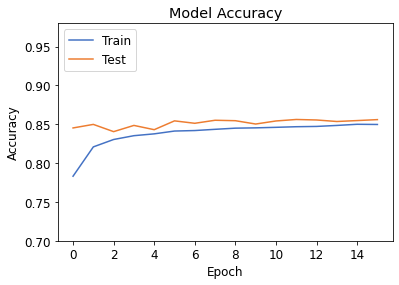

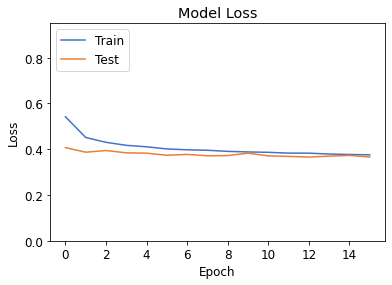

In [33]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'], color = '#4472C4')
plt.plot(history.history['val_accuracy'], color = '#ED7D31')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0.7,0.98)
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('results/DNN_accuracy_Class.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'], color = '#4472C4')
plt.plot(history.history['val_loss'], color = '#ED7D31')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.ylim(0,0.95)
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('results/DNN_loss_Class.png')
plt.show()

F1-Score per Class: [0.90907985 0.84963662 0.78434659]
F1-Score on Micro average (micro calculates positive and negative values globally): 0.8490052955488765
F1-Score on Macro average (average of each class’s F-1 score): 0.8476876887284422
F1-Score on weighted average: 0.8441137961102889
______________________________________________________

              precision    recall  f1-score   support

         Low       0.84      1.00      0.91      7494
      Medium       0.80      0.90      0.85     11267
        High       0.96      0.66      0.78      9187

    accuracy                           0.85     27948
   macro avg       0.87      0.85      0.85     27948
weighted avg       0.86      0.85      0.84     27948



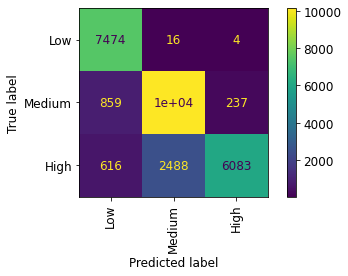

In [43]:
#note in kera model.predict() will return predict probabilities
y_pred =  hypermodel.predict(X_test, verbose=0)

prediction_class = []
for i in range(len(y_pred)):
    if y_pred[i][0] > y_pred[i][1] and y_pred[i][0] > y_pred[i][2]:
        prediction_class.append(0)
    if y_pred[i][1] > y_pred[i][0] and y_pred[i][1] > y_pred[i][2]:
        prediction_class.append(1)
    if y_pred[i][2] > y_pred[i][0] and y_pred[i][2] > y_pred[i][1]:
        prediction_class.append(2)

#f1_score(y_test_class, y_pred, average=None)

prediction_class = np.array(prediction_class)
print("F1-Score per Class: %s" % f1_score(y_test_class, prediction_class, average=None)) 
print("F1-Score on Micro average (micro calculates positive and negative values globally): %s" % f1_score(y_test_class, prediction_class, average='micro')) 
print("F1-Score on Macro average (average of each class’s F-1 score): %s" % f1_score(y_test_class, prediction_class, average='macro')) 
print("F1-Score on weighted average: %s" % f1_score(y_test_class, prediction_class, average='weighted')) 
print('______________________________________________________')
print('')
print(classification_report(y_test_class, prediction_class, target_names=['Low','Medium','High']))

ConfusionMatrixDisplay.from_predictions(y_test_class, prediction_class, display_labels=['Low','Medium','High'], xticks_rotation="vertical")
plt.tight_layout()
plt.savefig('results/DNN_Class_Confusion.png')
#plt.tight_layout()
plt.show()

In [46]:
cohen_kappa = cohen_kappa_score(y_test_class, prediction_class)
cohen_kappa

0.7701497304470755

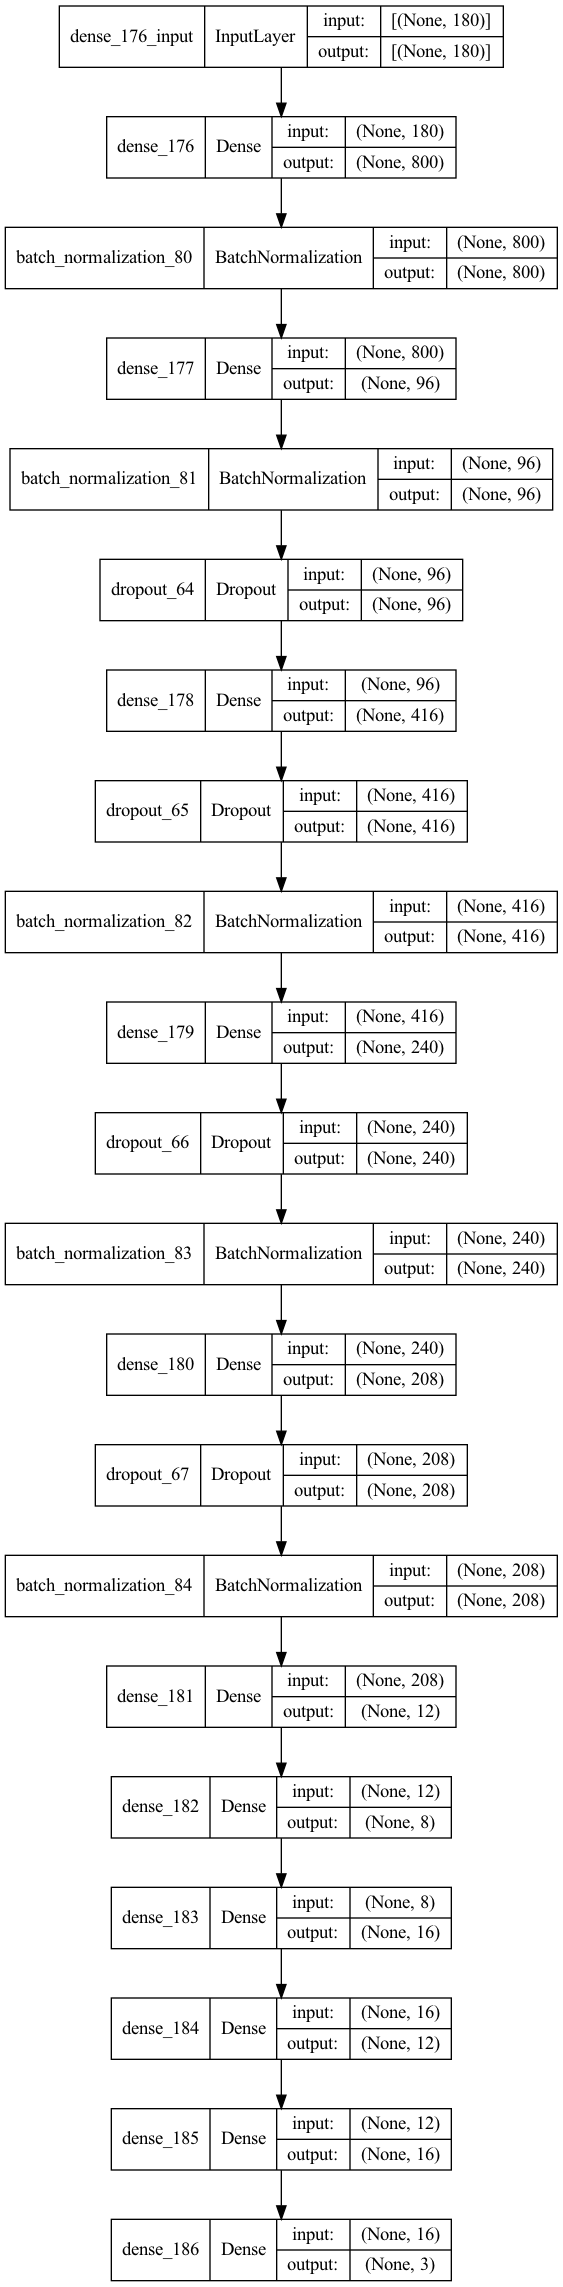

In [35]:
# Print Model Layout:
plot_model(hypermodel, to_file='results/hypermodel_class.png', show_shapes=True)

In [36]:
eval_result = hypermodel.evaluate(X_test, y_test_class)
print("[test loss, test sparse_categorical_crossentropy,test accuracy]:", eval_result)

874/874 [==============================] - 1s 2ms/step - loss: 0.3821 - sparse_categorical_crossentropy: 0.3821 - accuracy: 0.8490
[test loss, test sparse_categorical_crossentropy,test accuracy]: [0.38208693265914917, 0.38208693265914917, 0.8490052819252014]


## KFold Cross-Validation

In [48]:
# Define the K-fold Cross Validator

if cross_validation:

    num_folds = 10
    kfold = KFold(n_splits=num_folds, shuffle=True)

    # K-fold Cross Validation model evaluation
    fold_no = 1
    scores = []
    

    inputs = np.concatenate((X_train, X_test), axis=0)
    targets = np.concatenate((y_train_class, y_test_class), axis=0)

    for train, test in kfold.split(inputs, targets):

        best_model = tuner.hypermodel.build(best_hps)

        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        best_model.fit(inputs[train], targets[train], epochs=best_epoch, verbose=0, callbacks = [stop_early])
        score = model.evaluate(inputs[test], targets[test], verbose=0)
        
        y_pred =  best_model.predict(inputs[test], verbose=0)

        prediction_class = []
        for i in range(len(y_pred)):
            if y_pred[i][0] > y_pred[i][1] and y_pred[i][0] > y_pred[i][2]:
                prediction_class.append(0)
            if y_pred[i][1] > y_pred[i][0] and y_pred[i][1] > y_pred[i][2]:
                prediction_class.append(1)
            if y_pred[i][2] > y_pred[i][0] and y_pred[i][2] > y_pred[i][1]:
                prediction_class.append(2)
        
        score.append(cohen_kappa_score(targets[test], prediction_class))
        print(f'Score [test loss, test sparse_categorical_crossentropy,test accuracy, cohen kappa score] for fold {fold_no}: {score}')
        
        #yhat = model.predict(inputs[test])
        #print('MAE: %.3f' % mean_absolute_error(targets[test], yhat))

        #MAE_per_fold.append(mean_absolute_error(targets[test], yhat))
        #loss_per_fold.append(score)
        scores.append(score)
        # Increase fold number
        fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Score [test loss, test sparse_categorical_crossentropy,test accuracy, cohen kappa score] for fold 1: [0.5145829319953918, 0.5145829319953918, 0.8709746599197388, 0.7779129657028337]
------------------------------------------------------------------------
Training for fold 2 ...
Score [test loss, test sparse_categorical_crossentropy,test accuracy, cohen kappa score] for fold 2: [0.5183367729187012, 0.5183367729187012, 0.867825984954834, 0.7791259695456184]
------------------------------------------------------------------------
Training for fold 3 ...
Score [test loss, test sparse_categorical_crossentropy,test accuracy, cohen kappa score] for fold 3: [0.5494611263275146, 0.5494611263275146, 0.8621726036071777, 0.7733760244733898]
------------------------------------------------------------------------
Training for fold 4 ...
Score [test loss, test sparse_categorical_crossentropy,test accurac

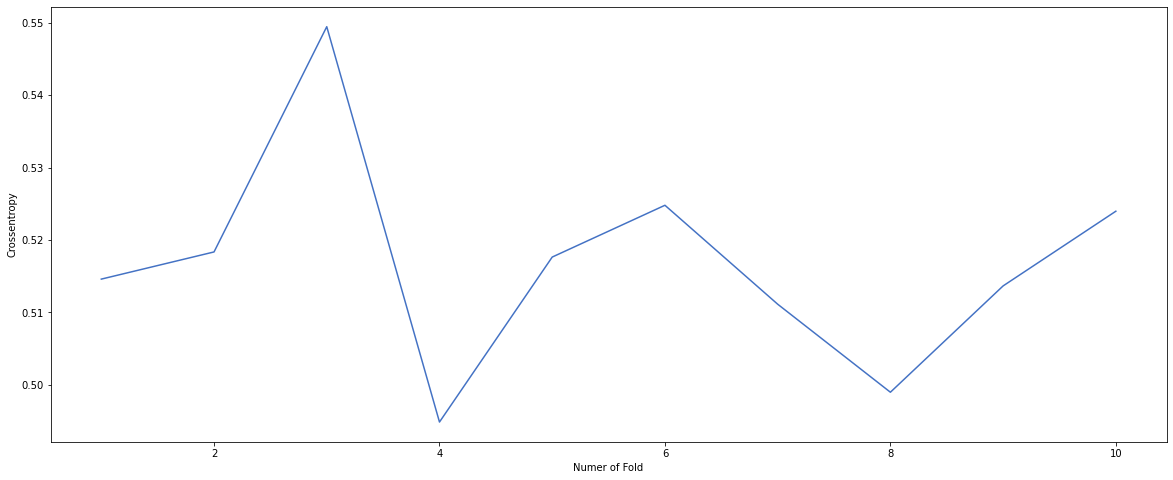

In [49]:
plt.figure(figsize=(20, 8))
#Create the plots
sparse_categorical_crossentropy = []
accuracy = []
cohen = []

for a_tuple in scores:
    sparse_categorical_crossentropy.append(a_tuple[1])
    accuracy.append(a_tuple[2])
    cohen.append(a_tuple[-1])
    
#plt.plot(range(1,len(scores)+1),accuracy, color='blue', label = 'accuracy')
plt.plot(range(1,len(scores)+1),sparse_categorical_crossentropy, color = '#4472C4', label = 'sparse_categorical_crossentropy')
#Create the title, axis description and legend
#plt.title('Results KFOLD Cross-Validation')
plt.ylabel('Crossentropy')
plt.xlabel("Numer of Fold")
#plt.legend()
#plt.grid()
plt.savefig('results/DNN_KFold_Crossentropy.png')
plt.xticks(rotation = 0)
plt.rcParams.update({'font.size': 12})

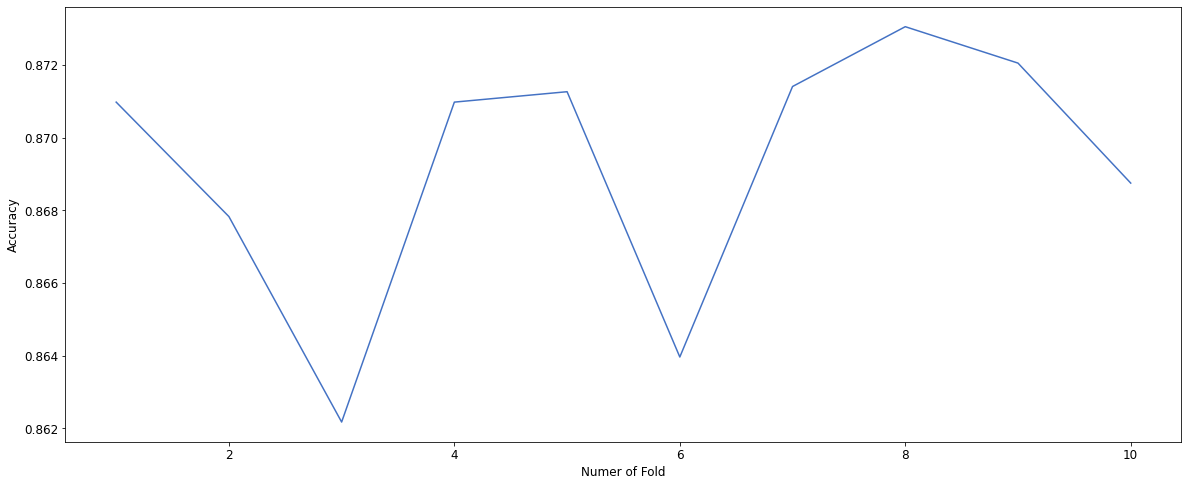

In [50]:
plt.figure(figsize=(20, 8))
plt.plot(range(1,len(scores)+1),accuracy, color = '#4472C4', label = 'accuracy')
#plt.plot(range(1,len(scores)+1),sparse_categorical_crossentropy, color='red', label = 'sparse_categorical_crossentropy')
#Create the title, axis description and legend
#plt.title('Results KFOLD Cross-Validation')
plt.ylabel('Accuracy')
plt.xlabel("Numer of Fold")
#plt.legend()
#plt.grid()
plt.xticks(rotation = 0)
plt.savefig('results/DNN_KFold_Accuracy.png')
plt.rcParams.update({'font.size': 12})

In [51]:
statistics.mean(accuracy)

0.8692419469356537

In [52]:
statistics.mean(cohen)

0.7752993095091462